# Introduction

## Purpose

The idea is to generate a bokeh graph to interactively explore 2.5 dimensional scattered data from a netCDF document.

On the basis of a netCDF document, an easy reproduceable example will be demonstrated. In the code showed below, we will produce a temperature-salinity diagram with colored chlorophyll data as z-data axis.

The data comes from the publicity available socib data (www.socib.es).

## Dependencies

This example is based upon the following python packages:
<ul>
    <li>numpy</li>
    <li>matplotlib</li>
    <li>bokeh</li>
    <li>netCDF4</li>
</ul>

Where the use of numpy, matplotlib and netCDF4 can be skipped, if the data (including color-codes) is coming from other sources.

# ScatterBokeh

The following instructions will produce a bokeh-based temperature-salinity diagram with a colorbar specified by the input chlorophyll as z-axis.

If needed, the whole code can be wrapped into an own package.

## Define data basis

First of all, we will import the (for this example) necessary python packages:

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.cm as cm
from matplotlib import colors as mcolors
from bokeh.plotting import figure
from bokeh.models import Plot, Rect, Text, Range1d
from bokeh.io import output_notebook, gridplot, show

Now we will define the input data source and will load the desired data columns from the netCDF file.

In [2]:
root = Dataset('http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep00-scb_sldeep000/L1/2015/dep0015_sdeep00_scb-sldeep000_L1_2015-08-19_data_dt.nc')
temperature = root.variables.get('temperature')
salinity = root.variables.get('salinity')
chlorophyll = root.variables.get('chlorophyll')

## Define functions

To get the whole processing reasonably reproductive, we define some functions to extract and convert the data, as well as to outsource the whole plotting definitions.

### Data extraction, conversions

Many netCDF variables (also those used in this example) are provided by an \_FillValue attribute, NaN values will be overwritten with the \_FillValue value. Since we can not benefit from this \_FillValue, we will instead use np.nan values.

In [3]:
def fill_with_nans(data_array):
    fill_value = data_array._FillValue
    data_array = get_data_array(data_array)
    idx = np.where(data_array == fill_value)
    data_array[idx] = np.nan
    return data_array

In [4]:
def get_data_array(data_array):
    if type(data_array.__array__()) is np.ma.masked_array:
        return data_array.__array__().data
    else:
        return data_array.__array__()

### Plot generation

To get a matplotlib color palette for the bokeh plotting colors, we will convert the matplotlib rgb colors to hex data.

In [5]:
def get_bokeh_palette(color_name):
    colormap = cm.get_cmap(color_name) 
    bokeh_palette = [mcolors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]
    return bokeh_palette

Furthermore, we have to assign the z-axis data (in our case the chlorophyll) to the defined color palette. Actually, we only provide a linear solution (256 same sized intervals). However, it is possible to extend this approach for logarithmic scales.

In [6]:
def assign_data_to_color_palette(z_data, hex_palette):
    data_min = np.nanmin(z_data)
    data_max = np.nanmax(z_data)
    abs_range = abs(data_min) + abs(data_max)
    abs_range = abs_range/256.0

    color_list=np.zeros(shape=(len(z_data),1),dtype=object)
    counter = 0
    for j in z_data:
        color_list[counter] = ""
        counter += 1

    counter=1
    lower_limit = data_min
    for i in hex_palette:
        upper_limit = data_min + abs_range*counter
        test = np.where((z_data >= lower_limit) & (z_data <= upper_limit))
        color_list[test] = i
        counter += 1
        lower_limit = upper_limit
    return color_list

Finally, we have to specify a bokeh plot together with our specifications. The following function will return a bokeh grid instance.

In [7]:
def plot_bokeh_scatter(x_data, y_data, z_data, matplotlib_palette_name="jet", title_label="", x_label="", y_label=""):
    
    [x_data, y_data, z_data] = map(fill_with_nans, [x_data, y_data, z_data])
    idx = np.where(~np.isnan(z_data))[0]
    [x_data, y_data, z_data] = [x_data[idx], y_data[idx], z_data[idx]]
    
    bokeh_palette = get_bokeh_palette(matplotlib_palette_name)
    z_color_list = assign_data_to_color_palette(z_data, bokeh_palette)
    
    fig = figure(title=title_label, tools=["pan, box_zoom, xwheel_zoom, save, reset, resize"])
    
    fig.scatter(x_data, y_data, fill_color=z_color_list[:,0], radius=0.001, fill_alpha=0.5, line_color=None)
    
    xdr = Range1d(0, 250)
    ydr = Range1d(0, 50)
    plot = Plot(x_range=xdr,
            y_range=ydr,
            title="",)

    for index, color in enumerate(bokeh_palette):
        width = 0.2
        rect = Rect(
            x=0, y=((width * index)),
            width=20, height=1,
            fill_color=color, line_color=None
        )
        plot.add_glyph(rect)
    zero = Text(x=20, y=0, text=[str(np.nanmin(z_data))])
    hundred = Text(x=20, y=48, text=[str(np.nanmax(z_data))])
    plot.add_glyph(zero)
    plot.add_glyph(hundred)
    plot.outline_line_color=None 
    fig.xaxis.axis_label=x_label
    fig.yaxis.axis_label=y_label
    p = gridplot([[fig, plot]])
    return p

## Call our function

We do not want bokeh to store the plot in a seperate window / file. That's why we call the function output_noteboo(), which generates the plot directly within the ipython notebook output.


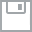
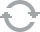
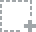
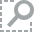
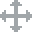
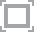
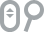
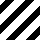
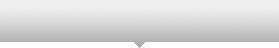
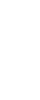
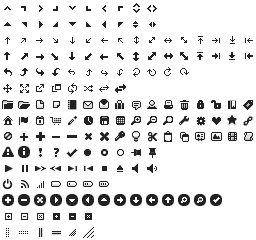
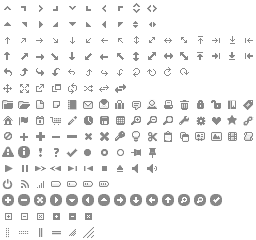
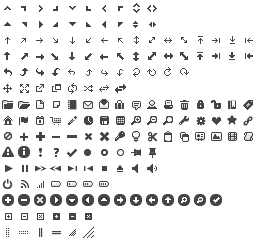
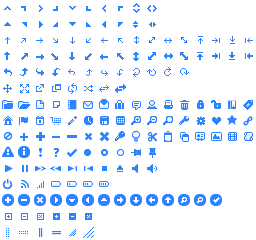
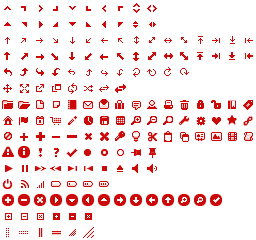
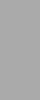
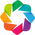
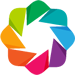

In [8]:
output_notebook()
g = plot_bokeh_scatter(salinity, temperature, chlorophyll, title_label="T-S Scatter Chlorophyll", 
                       x_label="Salinity", y_label="Temperature")
show(g)

As one can easily see, we just call a simple function and the remainder is performed within the function. 